# Read from the storage database

In [1]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

# ETL settings

In [2]:
# for which day to plot
DAY = "2020-02-03" # day to extract from the db

In [4]:
# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)
data_dose_rs = con.resample_10_seconds(df=data_dose, cols=['dose', 'dose_voltage', 'dose_corrected'], day=DAY)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0
data_hv_rs = con.resample_10_seconds(df=data_hv, cols=['HV_voltage', 'HV_current'], day=DAY)
# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)
data_pressure_rs = con.resample_10_seconds(df=data_pressure, cols=['pressure_IS', 'pressure_VC', 'pressure_IS_corrected'], day=DAY)

In [6]:
data_hv

,id,HV_voltage,HV_current,HV_current_x100
time,,,,
2020-02-03 00:00:00.352570,15694680,0.0,0.0,0.0
2020-02-03 00:00:01.355751,15694681,0.0,0.0,0.0
2020-02-03 00:00:02.355305,15694682,0.0,0.0,0.0
2020-02-03 00:00:03.354563,15694683,0.0,0.0,0.0
2020-02-03 00:00:04.357680,15694684,0.0,0.0,0.0
...,...,...,...,...
2020-02-03 02:59:59.456674,15705467,0.0,0.0,0.0
2020-02-03 03:00:00.455918,15705468,0.0,0.0,0.0
2020-02-03 03:00:01.459743,15705469,0.0,0.0,0.0


# Plots

In [19]:
data_dose.head()

,id,dose,dose_voltage,dose_corrected
time,,,,
2019-12-19 00:00:00.632895,12579566,38.1818,0.07,0.399449
2019-12-19 00:00:01.635933,12579567,38.1818,0.07,0.399449
2019-12-19 00:00:02.635549,12579568,38.1818,0.07,0.399449
2019-12-19 00:00:03.638674,12579569,38.1818,0.07,0.399449
2019-12-19 00:00:04.638193,12579570,38.1818,0.07,0.399449


## Plot dose whole day

Text(0.5,0,'Time, 2020-02-03')

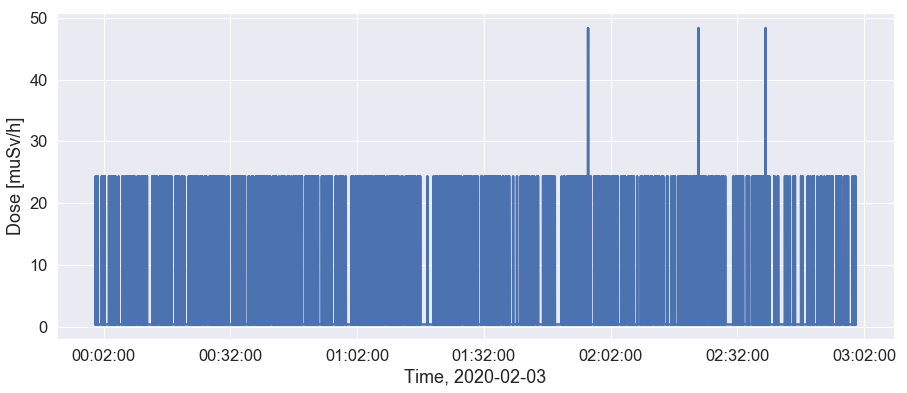

In [8]:
fig, ax = plt.subplots(figsize=(15,6))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax)
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
# ax.set(yscale="log")
ax.set_ylabel('Dose [muSv/h]')
ax.set_xlabel(f'Time, {DAY}')
# plt.savefig(f'{path}_dose_only.png', dpi=600, format='png')

## Plot pressure and HV 

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


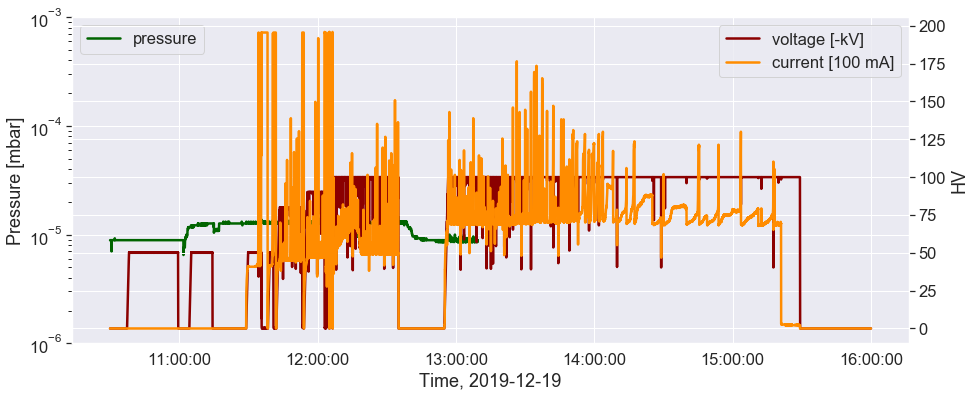

In [21]:
# select a subset of the day
time_start = f'{day} 10:30:00'
time_end = f'{day} 16:00:00'

df_hv = data_hv.loc[time_start:time_end,:]
# scale current by 100
df_hv['HV_current_x100'] = df_hv['HV_current']*100.0
df_pressure = data_pressure.loc[time_start:time_end,:]

fig, ax = plt.subplots(figsize=(15,6))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=df_pressure.index, y='pressure_IS_corrected', data=df_pressure, color='darkgreen', ax=ax, label='pressure')
plt.legend(loc='upper left')

ax2 = ax.twinx()
sns.lineplot(x=df_hv.index, y='HV_voltage', data=df_hv, ax=ax2, color='darkred', label='voltage [-kV]')
sns.lineplot(x=df_hv.index, y='HV_current_x100', data=df_hv, ax=ax2, color='darkorange', label='current [100 mA]')
plt.legend(loc='upper right')

ax.set(yscale="log")
ax.set_ylabel('Pressure [mbar]')
ax2.set_ylabel('HV')

ax.set_xlabel(f'Time, {day}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
ax.set_ylim(1e-6, 1e-3)

plt.savefig(f'{path}_pressure_hv.png', dpi=600, format='png')
plt.show()

## Plot dose and HV 

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


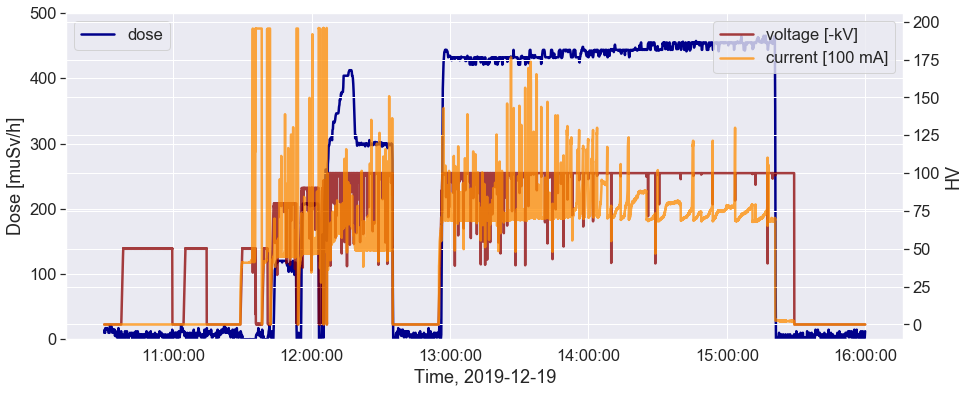

In [22]:
# select a subset of the day
time_start = f'{day} 10:30:00'
time_end = f'{day} 16:00:00'

df_hv = data_hv.loc[time_start:time_end,:]
# scale current by 100
df_hv['HV_current_x100'] = df_hv['HV_current']*100.0
df_dose = data_dose_rs.loc[time_start:time_end,:]

fig, ax = plt.subplots(figsize=(15,6))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=df_dose.index, y='dose_corrected', data=df_dose, color='darkblue', ax=ax, label='dose')
plt.legend(loc='upper left')

ax2 = ax.twinx()
sns.lineplot(x=df_hv.index, y='HV_voltage', data=df_hv, ax=ax2, color='darkred', label='voltage [-kV]', alpha=0.75)
sns.lineplot(x=df_hv.index, y='HV_current_x100', data=df_hv, ax=ax2, color='darkorange', label='current [100 mA]', alpha=0.75)
plt.legend(loc='upper right')

# ax.set(yscale="log")
ax.set_ylabel('Dose [muSv/h]')
ax2.set_ylabel('HV')

ax.set_xlabel(f'Time, {day}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
ax.set_ylim(0, 500)

plt.savefig(f'{path}_dose_hv.png', dpi=600, format='png')
plt.show()